# Tutorial 1

The aim of this first tutorial is to show in brief how this package can be used to solve a simple but non-trivial linear inverse problem. The methods used are only explained in outline, with later tutorials providing full details. 

The problem is as follows. We consider a function, $u$, defined on the interval $I = [0,1]$. We are given $n$ data of the form
$$
v_{i} = u(x_{i}) + z_{i}, 
$$
where the $x_{i}$ are known points and the $z_{i}$ are normally distributed random errors. From this data, the inverse problem aims to estimate $u$.

To proceed, we shall suppose that $u$ is an element of the Sobolev space, $H^{s}(I)$ with exponent $s>1/2$. On this space, it can be shown that the 
the inverse problem is well-define and can be solved using a range of methods that admit convergent numerical discretisations. 

The first code block sets up the model space, forward operator and data error measure. With these terms defined, we can then set up our forward problem. 

In [105]:
import numpy as np
import matplotlib.pyplot as plt
import pygeoinf as inf


# Set the interval properties
x1 = 0
x2 = 1
dx = 0.001

# Set the Sobolev parameters
exponent = 2
scale = 0.1

# Set up the model space. 
model_space = inf.homogeneous_space.line.Sobolev(x1, x2, dx, exponent, scale)


# Set the sample points randomly. 
n = 5
sample_points = np.random.uniform(x1,x2, n)

# Set the forward operator and data space.
forward_operator = model_space.point_evaluation_operator(sample_points)
data_space = forward_operator.codomain

# Set the data error measure using zero expectation and 
# covariance proportional to the identity. 
standard_deviation = 0.05
data_error_measure = inf.GaussianMeasure.from_standard_deviation(data_space, standard_deviation)

# Set up the forward problem 
forward_problem = inf.LinearForwardProblem(forward_operator, data_error_measure)


With the forward problem set up, we can now generate synthetic data for a given model. To do this, we introduce a Gaussian measure of the model space from which sample can be drawn. This prior measure will later be used within the Bayesian inversion, but for the moment it is just a convenient way to generate data. 

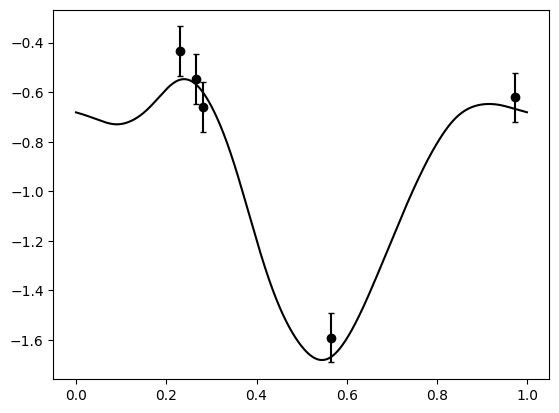

In [106]:
# Define a prior measure on the model space. 
model_prior_measure = model_space.sobolev_gaussian_measure(2,0.01,1)

# Sample a model and corresponding data. 
model, data = forward_problem.synthetic_model_and_data(model_prior_measure)

# Plot the function along with the corresponding data. 
model_space.plot(model, "k")
plt.errorbar(sample_points, data, 2 * standard_deviation, fmt="ko", capsize=2)
plt.show()

In our first approach to solving the inverse problem, we obtain a minimum norm solution. Of all the models that fit the data acceptably, this is the unique element with the smallest norm. This solution method yields a single prefered model but does not readily provide for a measure of uncertainty. 

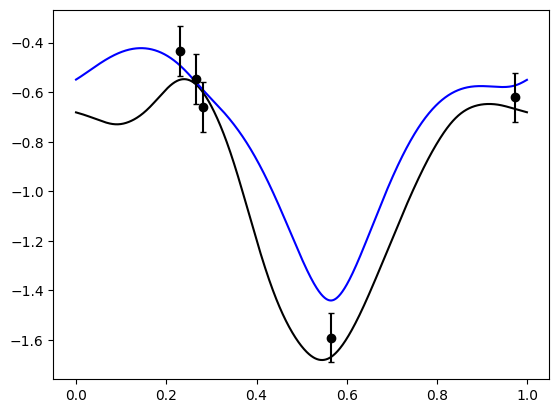

In [107]:
# Set up the inversion method. 
minimum_norm_inversion = inf.LinearMinimumNormInversion(forward_problem)

# Get the opreator that maps the data to the minimum norm solution. 
minimum_norm_operator = minimum_norm_inversion.minimum_norm_operator(inf.CGSolver())

# Compute and plot the minimum norm solution
minimum_norm_model = minimum_norm_operator(data)

model_space.plot(model, "k")
model_space.plot(minimum_norm_model, "b")
plt.errorbar(sample_points, data, 2 * standard_deviation, fmt="ko", capsize=2)
plt.show()


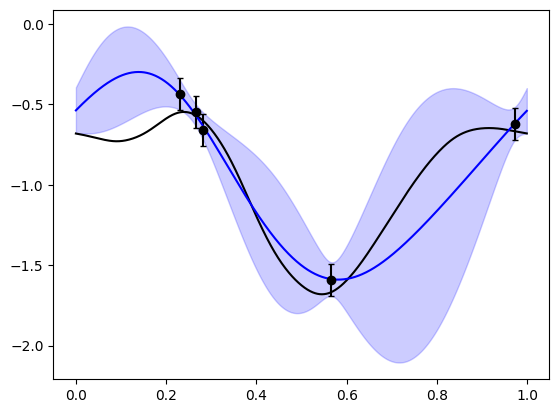

In [109]:


# Set up the inversion method. 
bayesian_inversion = inf.LinearBayesianInversion(forward_problem, model_prior_measure)

# Get the posterior distribiution. 
model_posterior_measure = bayesian_inversion.model_posterior_measure(data, inf.CholeskySolver())

# Estimate the pointwise variance
model_pointwise_variance = pointwise_variance(model_posterior_measure.low_rank_approximation(10, method="variable", rtol=1e-4), 200)
model_pointwise_std = np.sqrt(model_pointwise_variance)


# Plot the 
model_space.plot(model, "k")
plt.errorbar(sample_points, data, 2 * standard_deviation, fmt="ko", capsize=2)
model_space.plot(model_posterior_measure.expectation, "b")
model_space.plot_error_bounds(model_posterior_measure.expectation, 2 * model_pointwise_std, alpha=0.2, color="b")
plt.show()
